In [1]:
#%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt 
import cv2
import imageio
import SimpleITK
import sys
from pylab import *

In [2]:
img1=cv2.imread('IMG1.png',0)
img2=cv2.imread('IMG2.png',0)

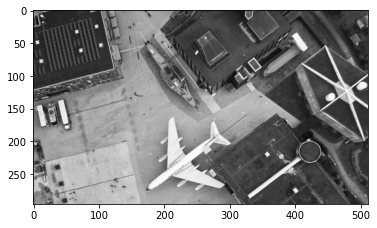

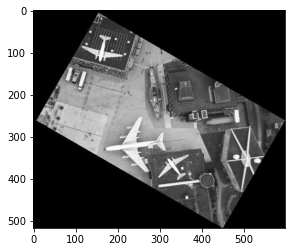

In [3]:
plt.imshow(img1,cmap='gray')
plt.show()

plt.imshow(img2,cmap='gray')
plt.show()

In [4]:
def bilinear_interpolate(zero_padded_source_image, x, y):
    # shape of the zero padded image
    dx, dy = np.shape(zero_padded_source_image)
    # get the shape of the original image
    dx, dy = dx-2, dy-2
    # +1 as we are taking coordinates with respect to a zero padded image
    x, y = x+1, y+1

    # x', y', a, b as defined in the lecture
    x_prime = int(np.floor(x))
    y_prime = int(np.floor(y))
    a = x-x_prime
    b = y-y_prime

    if x_prime >= 0 and x_prime <= dx and y_prime >= 0 and y_prime <= dy:
        # intensity value using bilinear interpolation
        intensity_val = (1-a)*(1-b)*zero_padded_source_image[x_prime, y_prime] \
            + (1-a)*b*zero_padded_source_image[x_prime, y_prime+1] \
            + a*(1-b)*zero_padded_source_image[x_prime+1, y_prime] \
            + a*b*zero_padded_source_image[x_prime+1, y_prime+1]
    else:
        # If the (xs, ys) does not exist in the source image, assign 0
        # for the corresponding (xt, yt) in the target image
        intensity_val = 0

    return intensity_val

In [5]:
def corresponding_points_2D(H, x):
    # x is of the form [x1, y1, 1], i.e., in homogenous coordinates.
    #  H is the homography matrix 
    x_prime = H@x
    if x_prime[-1]!=0:
        # return in non homogenous coordinates
        return x_prime[0]/x_prime[-1], x_prime[1]/x_prime[-1]
    else:
        # Homognous coordinates of the form [a, b, c] can be  
        # converted to non homogenous only if c!=0. In case that condition is
        # violated, we set the non homogenous coordinates to (0,0) even though
        # in reality such a point does not have a finite representation in
        # non homogenous coordinates
        return 0, 0

In [6]:
def A_matrix(points, corresponding_points):
    # Check that the number of points and their corresponding
    # points is equal
    #assert len(points) == len(corresponding_points), "Mismatch in number of points"
    n_correspondances = len(points)
    # from each point correspondance we get two values
    A_mat = np.zeros((2*n_correspondances, 5))
    for i in range(n_correspondances):
        x, y = points[i]
        x_prime, y_prime = corresponding_points[i]
        # As defined above
        A_mat[2*i] = [x, y, 1, 0, -x_prime]
        A_mat[2*i+1] = [y, -x, 0, 1, -y_prime]
    return A_mat

In [7]:
def compute_homography(A_matrix):
    # NumPy SVD gives singular values in decreasing order
    u, s, v_transpose = np.linalg.svd(A_matrix)
    # take the last row of v_transpose
    a, b, c, d, h = v_transpose[-1]
    # construct the appropriate 3x3 matrix
    H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)
    return H    

In [8]:
def transform_image(source_image, H):
    # zero padding the image for bilinear interpolation
    x, y = np.shape(source_image)
    image = np.zeros((x+2, y+2))
    image[1:-1, 1:-1] = source_image
    # Compute inv(H) to map target coordinates to source coordinates
    H_inv = np.linalg.inv(H)

    target_image = np.zeros((x, y))

    for xt in range(x):
        for yt in range(y):
            # convert to homogenous coordinates
            vec = np.array([xt, yt, 1])
            # calculate the corresponding points for
            # (xt, yt) in the source image
            xs, ys = corresponding_points_2D(H_inv, vec)
            # Assign the value using bilinear interpolation
            val = bilinear_interpolate(image, xs, ys)
            target_image[xt, yt] = val

    return target_image

In [9]:
points = np.array([[29, 124], [157, 372]])
corresponding_points = np.array([[93, 248], [328, 399]])
#assert len(points) == len(corresponding_points), "Number of points is not the same as the number of corresponding points"
n_correspondances = len(points)

In [10]:
A = A_matrix(corresponding_points, points)
H = compute_homography(A)
new_image = transform_image(img2, H)

<function matplotlib.pyplot.show(close=None, block=None)>

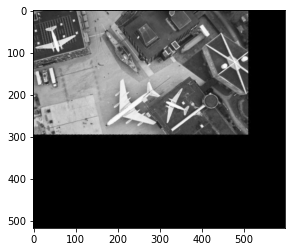

In [11]:
plt.imshow(new_image,cmap='gray')
plt.show

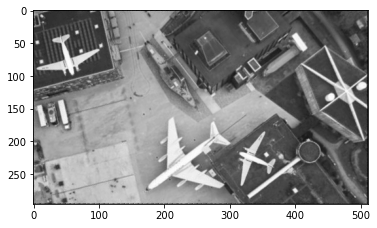

In [12]:
x1, y1 = np.shape(img1)
cropped = new_image[:x1, :y1]
plt.imshow(cropped,cmap='gray')
plt.show()

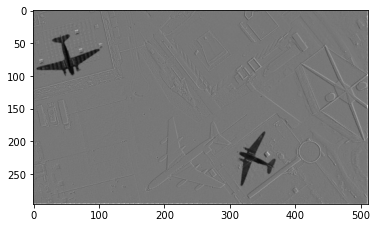

In [13]:
diff=img1-cropped
plt.imshow(diff,cmap='gray')
plt.show()